In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

# Configuration
IMG_SIZE = 128
BATCH_SIZE = 64
EPOCHS = 30
LEARNING_RATE = 0.0001
DATA_DIR = 'data'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VALID_DIR = os.path.join(DATA_DIR, 'valid')
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {DEVICE}")

Using device: cuda


## 1. Dataset Class with Preprocessing

In [15]:
class ASLDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.image_paths = []
        self.labels = []
        
        print(f"Scanning {root_dir}...")
        for cls in self.classes:
            cls_dir = os.path.join(root_dir, cls)
            for img_name in os.listdir(cls_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(cls_dir, img_name))
                    self.labels.append(self.class_to_idx[cls])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        # Read image
        img = cv2.imread(img_path)
        
        # Preprocessing: Grayscale + CLAHE
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        equalized = clahe.apply(gray)
        
        # Convert back to 3 channels for MobileNet compatibility
        img_processed = cv2.merge([equalized, equalized, equalized])
        
        # Resize
        img_processed = cv2.resize(img_processed, (IMG_SIZE, IMG_SIZE))
        
        # To Tensor
        img_tensor = transforms.ToTensor()(img_processed)
        
        if self.transform:
            img_tensor = self.transform(img_tensor)
            
        return img_tensor, label

## 2. Data Loaders

In [16]:
# Augmentation for training
train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
])

# Datasets
train_dataset = ASLDataset(TRAIN_DIR, transform=train_transform)
valid_dataset = ASLDataset(VALID_DIR)

NUM_CLASSES = len(train_dataset.classes)
print(f"Classes: {NUM_CLASSES}")

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

Scanning data\train...
Scanning data\valid...
Classes: 27


## 3. MobileNetV2 Model Setup

In [17]:
# --- MobileNetV2 Architecture Definition ---
class ConvBNReLU(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        super(ConvBNReLU, self).__init__(
            nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=False),
            nn.BatchNorm2d(out_planes),
            nn.ReLU6(inplace=True)
        )

class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = int(round(inp * expand_ratio))
        self.use_res_connect = self.stride == 1 and inp == oup

        layers = []
        if expand_ratio != 1:
            # pw
            layers.append(ConvBNReLU(inp, hidden_dim, kernel_size=1))
        layers.extend([
            # dw
            ConvBNReLU(hidden_dim, hidden_dim, stride=stride, groups=hidden_dim),
            # pw-linear
            nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
            nn.BatchNorm2d(oup),
        ])
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

class MobileNetV2(nn.Module):
    def __init__(self, num_classes=1000, width_mult=1.0):
        super(MobileNetV2, self).__init__()
        block = InvertedResidual
        input_channel = 32
        last_channel = 1280
        
        interverted_residual_setting = [
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        # building first layer
        input_channel = int(input_channel * width_mult)
        self.last_channel = int(last_channel * width_mult) if width_mult > 1.0 else last_channel
        features = [ConvBNReLU(3, input_channel, stride=2)]
        
        # building inverted residual blocks
        for t, c, n, s in interverted_residual_setting:
            output_channel = int(c * width_mult)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(block(input_channel, output_channel, stride, expand_ratio=t))
                input_channel = output_channel
                
        # building last several layers
        features.append(ConvBNReLU(input_channel, self.last_channel, kernel_size=1))
        
        self.features = nn.Sequential(*features)
        
        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.last_channel, num_classes),
        )

        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.features(x)
        x = x.mean([2, 3])
        x = self.classifier(x)
        return x

# Initialize Model from Scratch
print("Initializing MobileNetV2 from scratch...")
model = MobileNetV2(num_classes=NUM_CLASSES)
model = model.to(DEVICE)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

Initializing MobileNetV2 from scratch...


## 4. Training Loop

In [18]:
history = {'accuracy': [], 'loss': [], 'val_accuracy': [], 'val_loss': []}
best_acc = 0.0

start_time = time.time()

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{EPOCHS}]", leave=True)
    
    for inputs, labels in loop:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        loop.set_postfix(loss=loss.item(), acc=correct/total)
    
    epoch_acc = correct / total
    epoch_loss = running_loss / len(train_loader)
    
    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_acc = val_correct / val_total
    val_epoch_loss = val_loss / len(valid_loader)
    
    print(f"Epoch [{epoch+1}/{EPOCHS}] Train Acc: {epoch_acc:.4f} Loss: {epoch_loss:.4f} | Val Acc: {val_acc:.4f} Loss: {val_epoch_loss:.4f}")
    
    history['accuracy'].append(epoch_acc)
    history['loss'].append(epoch_loss)
    history['val_accuracy'].append(val_acc)
    history['val_loss'].append(val_epoch_loss)
    
    # Save Best Model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'asl_mobilenet_v2.pth')
        print(f"Saved new best model with acc: {val_acc:.4f}")

print(f"Training finished in {time.time() - start_time:.2f}s")

Epoch [1/30]: 100%|██████████| 148/148 [00:50<00:00,  2.91it/s, acc=0.0748, loss=3.1] 


Epoch [1/30] Train Acc: 0.0748 Loss: 3.2212 | Val Acc: 0.1235 Loss: 2.8970
Saved new best model with acc: 0.1235


Epoch [2/30]: 100%|██████████| 148/148 [00:44<00:00,  3.30it/s, acc=0.228, loss=2.28]


Epoch [2/30] Train Acc: 0.2281 Loss: 2.5668 | Val Acc: 0.3546 Loss: 1.9768
Saved new best model with acc: 0.3546


Epoch [3/30]: 100%|██████████| 148/148 [00:45<00:00,  3.27it/s, acc=0.451, loss=1.73]


Epoch [3/30] Train Acc: 0.4511 Loss: 1.7959 | Val Acc: 0.6158 Loss: 1.2791
Saved new best model with acc: 0.6158


Epoch [4/30]: 100%|██████████| 148/148 [00:45<00:00,  3.26it/s, acc=0.628, loss=0.91] 


Epoch [4/30] Train Acc: 0.6279 Loss: 1.2217 | Val Acc: 0.7659 Loss: 0.7927
Saved new best model with acc: 0.7659


Epoch [5/30]: 100%|██████████| 148/148 [00:45<00:00,  3.26it/s, acc=0.763, loss=0.52] 


Epoch [5/30] Train Acc: 0.7630 Loss: 0.7996 | Val Acc: 0.8696 Loss: 0.4930
Saved new best model with acc: 0.8696


Epoch [6/30]: 100%|██████████| 148/148 [00:45<00:00,  3.25it/s, acc=0.838, loss=0.458]


Epoch [6/30] Train Acc: 0.8381 Loss: 0.5533 | Val Acc: 0.8993 Loss: 0.3505
Saved new best model with acc: 0.8993


Epoch [7/30]: 100%|██████████| 148/148 [00:45<00:00,  3.23it/s, acc=0.883, loss=0.262]


Epoch [7/30] Train Acc: 0.8826 Loss: 0.4001 | Val Acc: 0.9417 Loss: 0.2330
Saved new best model with acc: 0.9417


Epoch [8/30]: 100%|██████████| 148/148 [00:45<00:00,  3.26it/s, acc=0.913, loss=0.398]


Epoch [8/30] Train Acc: 0.9134 Loss: 0.3024 | Val Acc: 0.9536 Loss: 0.1846
Saved new best model with acc: 0.9536


Epoch [9/30]: 100%|██████████| 148/148 [00:45<00:00,  3.25it/s, acc=0.934, loss=0.169] 


Epoch [9/30] Train Acc: 0.9339 Loss: 0.2310 | Val Acc: 0.9644 Loss: 0.1455
Saved new best model with acc: 0.9644


Epoch [10/30]: 100%|██████████| 148/148 [00:45<00:00,  3.26it/s, acc=0.948, loss=0.122] 


Epoch [10/30] Train Acc: 0.9485 Loss: 0.1836 | Val Acc: 0.9684 Loss: 0.1116
Saved new best model with acc: 0.9684


Epoch [11/30]: 100%|██████████| 148/148 [00:45<00:00,  3.26it/s, acc=0.96, loss=0.119]  


Epoch [11/30] Train Acc: 0.9597 Loss: 0.1480 | Val Acc: 0.9728 Loss: 0.0950
Saved new best model with acc: 0.9728


Epoch [12/30]: 100%|██████████| 148/148 [00:45<00:00,  3.27it/s, acc=0.965, loss=0.15]  


Epoch [12/30] Train Acc: 0.9652 Loss: 0.1251 | Val Acc: 0.9783 Loss: 0.0753
Saved new best model with acc: 0.9783


Epoch [13/30]: 100%|██████████| 148/148 [00:45<00:00,  3.26it/s, acc=0.968, loss=0.0957]


Epoch [13/30] Train Acc: 0.9680 Loss: 0.1149 | Val Acc: 0.9798 Loss: 0.0685
Saved new best model with acc: 0.9798


Epoch [14/30]: 100%|██████████| 148/148 [00:45<00:00,  3.25it/s, acc=0.976, loss=0.0587]


Epoch [14/30] Train Acc: 0.9761 Loss: 0.0935 | Val Acc: 0.9817 Loss: 0.0645
Saved new best model with acc: 0.9817


Epoch [15/30]: 100%|██████████| 148/148 [00:44<00:00,  3.29it/s, acc=0.977, loss=0.087] 


Epoch [15/30] Train Acc: 0.9772 Loss: 0.0815 | Val Acc: 0.9822 Loss: 0.0623
Saved new best model with acc: 0.9822


Epoch [16/30]: 100%|██████████| 148/148 [00:45<00:00,  3.29it/s, acc=0.978, loss=0.0909]


Epoch [16/30] Train Acc: 0.9782 Loss: 0.0730 | Val Acc: 0.9877 Loss: 0.0469
Saved new best model with acc: 0.9877


Epoch [17/30]: 100%|██████████| 148/148 [00:45<00:00,  3.26it/s, acc=0.983, loss=0.0141]


Epoch [17/30] Train Acc: 0.9825 Loss: 0.0626 | Val Acc: 0.9872 Loss: 0.0478


Epoch [18/30]: 100%|██████████| 148/148 [00:45<00:00,  3.24it/s, acc=0.984, loss=0.0353] 


Epoch [18/30] Train Acc: 0.9842 Loss: 0.0565 | Val Acc: 0.9827 Loss: 0.0552


Epoch [19/30]: 100%|██████████| 148/148 [00:45<00:00,  3.24it/s, acc=0.987, loss=0.0133] 


Epoch [19/30] Train Acc: 0.9866 Loss: 0.0524 | Val Acc: 0.9847 Loss: 0.0426


Epoch [20/30]: 100%|██████████| 148/148 [00:45<00:00,  3.24it/s, acc=0.985, loss=0.166] 


Epoch [20/30] Train Acc: 0.9849 Loss: 0.0524 | Val Acc: 0.9827 Loss: 0.0497


Epoch [21/30]: 100%|██████████| 148/148 [00:45<00:00,  3.26it/s, acc=0.988, loss=0.0417] 


Epoch [21/30] Train Acc: 0.9875 Loss: 0.0465 | Val Acc: 0.9896 Loss: 0.0337
Saved new best model with acc: 0.9896


Epoch [22/30]: 100%|██████████| 148/148 [00:45<00:00,  3.25it/s, acc=0.987, loss=0.0716] 


Epoch [22/30] Train Acc: 0.9872 Loss: 0.0434 | Val Acc: 0.9891 Loss: 0.0368


Epoch [23/30]: 100%|██████████| 148/148 [00:45<00:00,  3.24it/s, acc=0.989, loss=0.174]  


Epoch [23/30] Train Acc: 0.9889 Loss: 0.0378 | Val Acc: 0.9886 Loss: 0.0370


Epoch [24/30]: 100%|██████████| 148/148 [00:45<00:00,  3.24it/s, acc=0.99, loss=0.0323] 


Epoch [24/30] Train Acc: 0.9898 Loss: 0.0345 | Val Acc: 0.9906 Loss: 0.0314
Saved new best model with acc: 0.9906


Epoch [25/30]: 100%|██████████| 148/148 [00:46<00:00,  3.20it/s, acc=0.991, loss=0.0305] 


Epoch [25/30] Train Acc: 0.9911 Loss: 0.0324 | Val Acc: 0.9886 Loss: 0.0346


Epoch [26/30]: 100%|██████████| 148/148 [00:45<00:00,  3.24it/s, acc=0.991, loss=0.0412] 


Epoch [26/30] Train Acc: 0.9911 Loss: 0.0310 | Val Acc: 0.9911 Loss: 0.0313
Saved new best model with acc: 0.9911


Epoch [27/30]: 100%|██████████| 148/148 [00:45<00:00,  3.25it/s, acc=0.991, loss=0.0251] 


Epoch [27/30] Train Acc: 0.9906 Loss: 0.0316 | Val Acc: 0.9901 Loss: 0.0317


Epoch [28/30]: 100%|██████████| 148/148 [01:00<00:00,  2.45it/s, acc=0.994, loss=0.0395] 


Epoch [28/30] Train Acc: 0.9935 Loss: 0.0244 | Val Acc: 0.9921 Loss: 0.0276
Saved new best model with acc: 0.9921


Epoch [29/30]: 100%|██████████| 148/148 [00:51<00:00,  2.86it/s, acc=0.992, loss=0.0159] 


Epoch [29/30] Train Acc: 0.9919 Loss: 0.0297 | Val Acc: 0.9911 Loss: 0.0274


Epoch [30/30]: 100%|██████████| 148/148 [00:50<00:00,  2.96it/s, acc=0.994, loss=0.102]  


Epoch [30/30] Train Acc: 0.9935 Loss: 0.0221 | Val Acc: 0.9881 Loss: 0.0389
Training finished in 1476.58s


## 5. Visualization

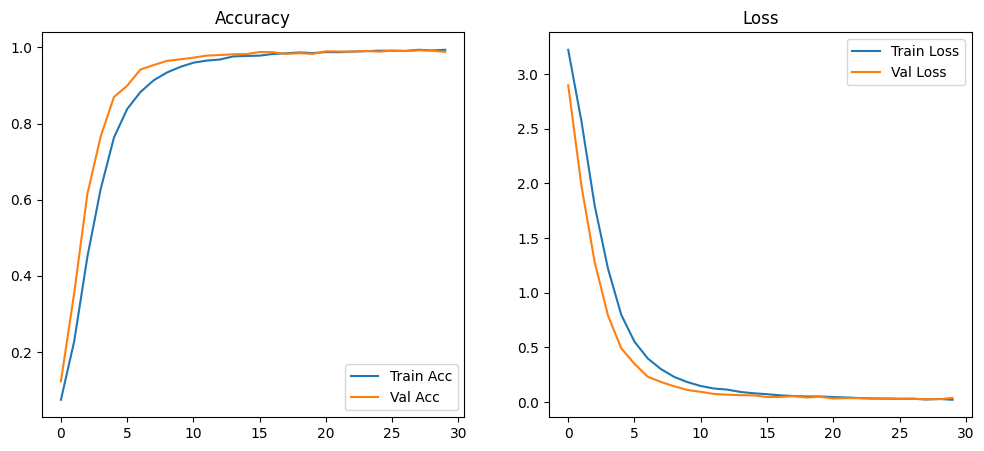

In [20]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Acc')
plt.plot(history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.show()